In [80]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import optuna

from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV


#Code to always set working directory one level up so we can access /data easily
import os
if "NOTEBOOK_DIR" not in globals():
    NOTEBOOK_DIR = os.getcwd()
    print('Notebook Directory Set:', os.getcwd())

os.chdir(os.path.join(NOTEBOOK_DIR, ".."))
print("Current working directory:", os.getcwd())

Current working directory: /shared_folder/eas_508_project


In [54]:
pbp_path = 'data/interim/pbp/'

pbp_name = 'featured_11_13.csv'

df = pd.read_csv(pbp_path + pbp_name, dtype={'personnel_num': 'string'})
shape = df.shape
columns = df.columns

print('✔✔✔ File Loaded\n')
print(f'Shape: {shape}\n')
print(f'Column Names: {list(columns)}\n')

df.head()

/tmp/ipykernel_39307/2280615120.py:5: DtypeWarning: Columns (84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(pbp_path + pbp_name, dtype={'personnel_num': 'string'})


✔✔✔ File Loaded

Shape: (307576, 114)

Column Names: ['nflverse_game_id', 'play_id', 'possession_team', 'offense_formation', 'offense_personnel', 'defenders_in_box', 'defense_personnel', 'n_offense', 'n_defense', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'yrdln', 'ydstogo', 'ydsnet', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'run_location', 'run_gap', 'score_differential', 'no_score_prob', 'fg_prob', 'td_prob', 'ep', 'epa', 'wp', 'def_wp', 'home_wp', 'away_wp', 'wpa', 'third_down_converted', 'third_down_failed', 'fourth_down_converted', 'fourth_down_failed', 'penalty', 'field_goal_attempt', 'complete_pass', 'passing_yards', 'receiving_yards', 'rushing_yards', 'season', 'order_sequence', 'stadium', 'weather', 'nfl_api_id', 'fixed_drive'

,nflverse_game_id,play_id,possession_team,offense_formation,offense_personnel,defenders_in_box,defense_personnel,n_offense,n_defense,home_team,...,fp_success,smoothed_fp_success,fp_epa,f_success,smoothed_f_success,f_epa,yard_group,previous_success,home,spread
0,2016_01_BUF_BAL,58,BAL,UNDER_CENTER,"2 RB, 1 TE, 2 WR",8.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,0.426230,0.426601,0.019530,0.429168,0.429205,0.010042,0to5,0.0,1,-3.0
1,2016_01_BUF_BAL,85,BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,0.464400,0.462669,0.057628,0.441437,0.441424,0.021173,0to5,1.0,1,-3.0
2,2016_01_BUF_BAL,109,BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,0.464400,0.462669,0.057628,0.441437,0.441424,0.021173,0to5,1.0,1,-3.0
3,2016_01_BUF_BAL,130,BAL,UNDER_CENTER,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,0.426230,0.426601,0.019530,0.429168,0.429205,0.010042,5to10,0.0,1,-3.0
4,2016_01_BUF_BAL,154,BAL,UNDER_CENTER,"1 RB, 2 TE, 2 WR",8.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,0.420136,0.420369,0.006901,0.429168,0.429205,0.010042,0to5,1.0,1,-3.0


In [ ]:
# Useable Features
features = ['down',
            'ydstogo',
            'ydstosuccess',
            'yard_group',
            'yardline_100',
            'previous_success',
            'success',
            'offense_formation',
            'defenders_in_box',
            'QB',
            'RB',
            'TE',
            'WR',
            'OL',
            'O_OTHER',
            'DL',
            'LB',
            'DB',
            'D_OTHER',
            'home',
            'score_differential',
            'spread',
            'total_line',
            'qtr',
            'quarter_seconds_remaining']
cat_features = ['yard_group',
                'offense_formation']
target = 'success'

In [ ]:
model_df = df[features]
for col in cat_features:
    model_df[col] = model_df[col].astype(str)
    model_df[col] = LabelEncoder().fit_transform(model_df[col])
model_df = model_df.copy()

X = model_df.drop(columns=target)
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=42, stratify=model_df[target])

In [121]:
model = xgb.XGBClassifier(
    n_estimators = 500,
    learning_rate = .05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [122]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

print(classification_report(y_test, y_pred))

Accuracy: 0.5814097145458093
AUC: 0.5884092370202758
              precision    recall  f1-score   support

         0.0       0.60      0.76      0.67     34651
         1.0       0.53      0.35      0.42     26865

    accuracy                           0.58     61516
   macro avg       0.57      0.56      0.55     61516
weighted avg       0.57      0.58      0.56     61516



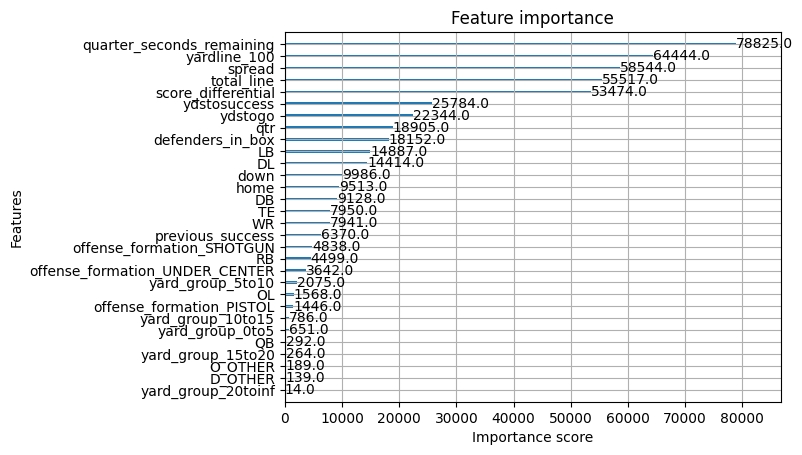

In [123]:
xgb.plot_importance(model)
plt.show()

Down 1 prediction reports
              precision    recall  f1-score   support

         0.0       0.59      0.80      0.68     15761
         1.0       0.48      0.25      0.33     11630

    accuracy                           0.57     27391
   macro avg       0.53      0.52      0.50     27391
weighted avg       0.54      0.57      0.53     27391

Down 2 prediction reports
              precision    recall  f1-score   support

         0.0       0.59      0.71      0.65     11229
         1.0       0.54      0.41      0.47      9257

    accuracy                           0.58     20486
   macro avg       0.57      0.56      0.56     20486
weighted avg       0.57      0.58      0.57     20486

Down 3 prediction reports
              precision    recall  f1-score   support

         0.0       0.64      0.75      0.69      7120
         1.0       0.58      0.44      0.50      5368

    accuracy                           0.62     12488
   macro avg       0.61      0.60      0.60     12

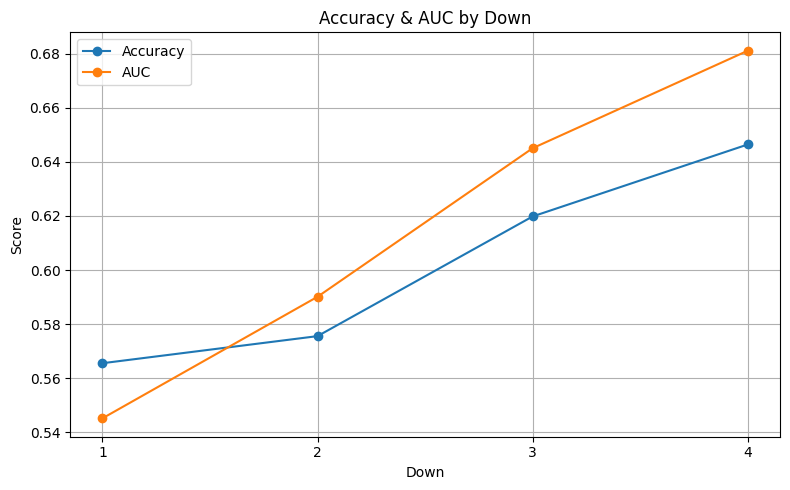

In [125]:
auc = []
acc = []

for down in range(1,5):
    idx = X_test['down']==down
    print(f'Down {down} prediction reports')
    print(classification_report(y_test[idx], y_pred[idx]))
    acc.append(accuracy_score(y_test[idx], y_pred[idx]))
    auc.append(roc_auc_score(y_test[idx], y_proba[idx]))

downs = np.arange(1, 5)

plt.figure(figsize=(8,5))
plt.plot(downs, acc, marker='o', label='Accuracy')
plt.plot(downs, auc, marker='o', label='AUC')

plt.xticks(downs)
plt.xlabel("Down")
plt.ylabel("Score")
plt.title("Accuracy & AUC by Down")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Down 4 prediction reports
              precision    recall  f1-score   support

         0.0       0.60      0.77      0.67      7867
         1.0       0.53      0.34      0.41      6192

    accuracy                           0.58     14059
   macro avg       0.56      0.55      0.54     14059
weighted avg       0.57      0.58      0.56     14059

Down 4 prediction reports
              precision    recall  f1-score   support

         0.0       0.59      0.74      0.66      9198
         1.0       0.53      0.36      0.43      7404

    accuracy                           0.57     16602
   macro avg       0.56      0.55      0.54     16602
weighted avg       0.56      0.57      0.56     16602

Down 4 prediction reports
              precision    recall  f1-score   support

         0.0       0.60      0.76      0.67      7955
         1.0       0.53      0.35      0.42      6172

    accuracy                           0.58     14127
   macro avg       0.57      0.56      0.55     14

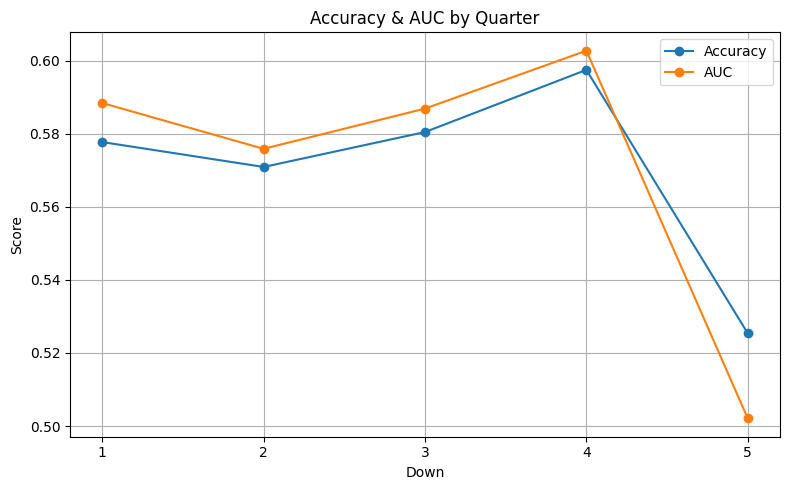

In [128]:
auc = []
acc = []

for qtr in range(1,6):
    idx = X_test['qtr']==qtr
    print(f'Down {down} prediction reports')
    print(classification_report(y_test[idx], y_pred[idx]))
    acc.append(accuracy_score(y_test[idx], y_pred[idx]))
    auc.append(roc_auc_score(y_test[idx], y_proba[idx]))

downs = np.arange(1, 6)

plt.figure(figsize=(8,5))
plt.plot(downs, acc, marker='o', label='Accuracy')
plt.plot(downs, auc, marker='o', label='AUC')

plt.xticks(downs)
plt.xlabel("Down")
plt.ylabel("Score")
plt.title("Accuracy & AUC by Quarter")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [126]:
df.qtr.value_counts()

qtr
2    82963
4    82291
3    70452
1    69877
5     1993
Name: count, dtype: int64

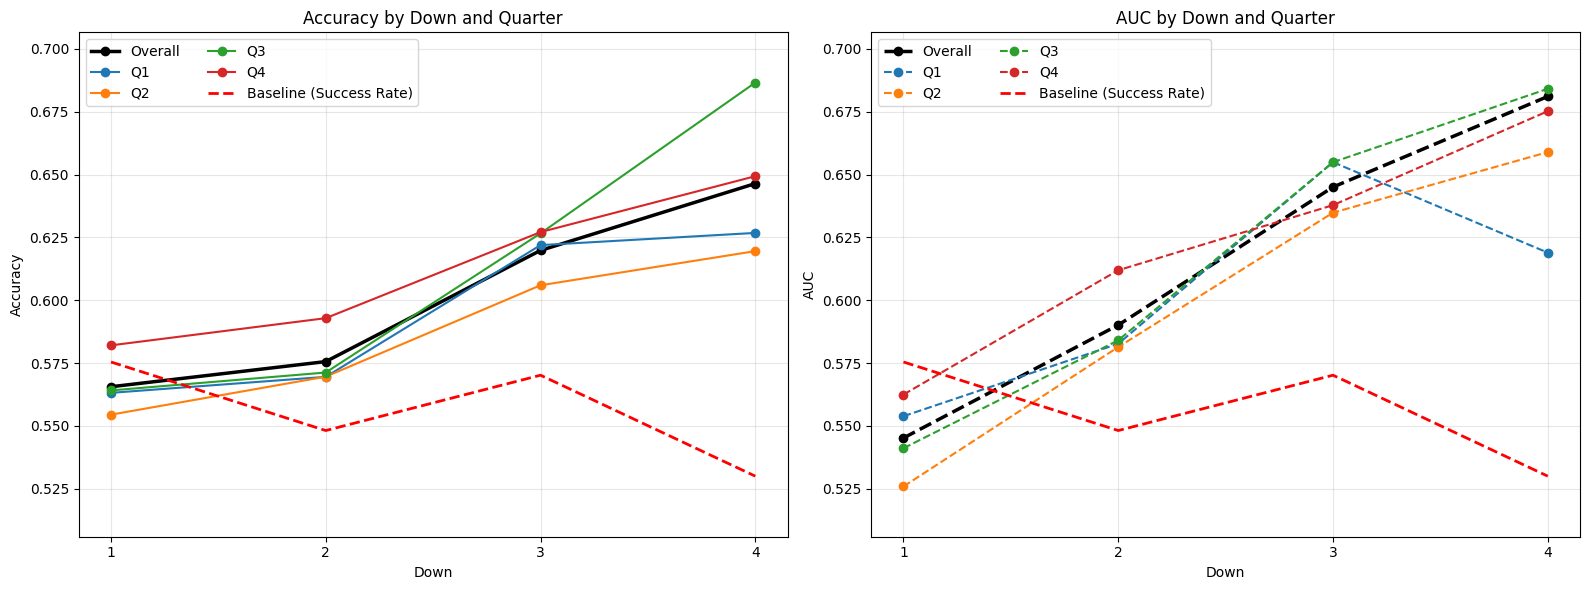

In [136]:
downs = [1, 2, 3, 4]
quarters = [1, 2, 3, 4]

acc_overall, auc_overall = [], []
acc_q = {q: [] for q in quarters}
auc_q = {q: [] for q in quarters}

# ---- overall by-down ----
for d in downs:
    idx = X_test['down'] == d
    acc_overall.append(accuracy_score(y_test[idx], y_pred[idx]))
    auc_overall.append(roc_auc_score(y_test[idx], y_proba[idx]))

# ---- baseline by down (quarter ignored) ----
baseline_down = []
for d in downs:
    idx = X_test['down'] == d
    baseline_down.append(np.max([1-y_test[idx].mean(),y_test[idx].mean()]))

# ---- quarter-specific by-down ----
for q in quarters:
    for d in downs:
        idx = (X_test['down'] == d) & (X_test['qtr'] == q)
        if idx.sum() == 0:
            acc_q[q].append(np.nan)
            auc_q[q].append(np.nan)
        else:
            acc_q[q].append(accuracy_score(y_test[idx], y_pred[idx]))
            auc_q[q].append(roc_auc_score(y_test[idx], y_proba[idx]))

# ---- compute shared y-limits including baseline ----
all_vals = (
    acc_overall + auc_overall +
    baseline_down +
    [v for q in quarters for v in acc_q[q]] +
    [v for q in quarters for v in auc_q[q]]
)

ymin = np.nanmin(all_vals)
ymax = np.nanmax(all_vals)
ylim = (ymin - 0.02, ymax + 0.02)


# ------------------ PLOTS ------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# ------------------ ACCURACY PLOT ------------------
ax = axes[0]
ax.plot(downs, acc_overall, marker='o', linewidth=2.5, color='black', label='Overall')
for q in quarters:
    ax.plot(downs, acc_q[q], marker='o', label=f'Q{q}')

# per-down baseline
ax.plot(downs, baseline_down, color='red', linestyle='--', linewidth=2, label='Baseline (Success Rate)')

ax.set_title("Accuracy by Down and Quarter")
ax.set_xlabel("Down")
ax.set_ylabel("Accuracy")
ax.set_xticks(downs)
ax.set_ylim(ylim)
ax.grid(True, alpha=0.3)
ax.legend(ncol=2)

# ------------------ AUC PLOT ------------------
ax = axes[1]
ax.plot(downs, auc_overall, marker='o', linewidth=2.5, color='black', linestyle='--', label='Overall')
for q in quarters:
    ax.plot(downs, auc_q[q], marker='o', linestyle='--', label=f'Q{q}')

# per-down baseline again
ax.plot(downs, baseline_down, color='red', linestyle='--', linewidth=2, label='Baseline (Success Rate)')

ax.set_title("AUC by Down and Quarter")
ax.set_xlabel("Down")
ax.set_ylabel("AUC")
ax.set_xticks(downs)
ax.set_ylim(ylim)
ax.grid(True, alpha=0.3)
ax.legend(ncol=2)

plt.tight_layout()
plt.show()